# 1. Install MONAA

Download, build, and install  [MONAA](https://github.com/MasWag/monaa)

In [0]:
! git clone https://github.com/MasWag/monaa.git

Cloning into 'qtpm'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 572 (delta 35), reused 50 (delta 23), pack-reused 507
Receiving objects: 100% (572/572), 113.33 KiB | 637.00 KiB/s, done.
Resolving deltas: 100% (370/370), done.


In [0]:
! apt install cmake libboost-dev flex libeigen3-dev doxygen bison -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-dev is already the newest version (1.65.1.0ubuntu1).
libboost-dev set to manually installed.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following additional packages will be installed:
  libbison-dev libfl-dev libfl2 libsigsegv2 libxapian30 m4
Suggested packages:
  bison-doc doxygen-latex doxygen-doc doxygen-gui flex-doc libeigen3-doc
  libmrpt-dev xapian-tools m4-doc
The following NEW packages will be installed:
  bison doxygen flex libbison-dev libeigen3-dev libfl-dev libfl2 libsigsegv2
  libxapian30 m4
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 6,472 kB of archives.
After this operation, 28.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsigsegv2 amd64 2.12-1 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 m4 amd64 1.4.18-1 [197 kB]
Get:3 http://arc

In [0]:
! mkdir -p monaa/build && cd monaa/build && cmake -DCMAKE_BUILD_TYPE=Release .. && make -j4  && make install

-- The CXX compiler identification is GNU 7.4.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found BISON: /usr/bin/bison (found version "3.0.4") 
-- Found FLEX: /usr/bin/flex (found version "2.6.4") 
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   program_options
--   unit_test_framework
--   iostreams
--   graph
--   regex
-- Found Doxygen: /usr/bin/doxygen (found version "1.8.13") found components:  doxygen dot 
-- Configuring done
-- Generating done
-- Build files have been written to: /content/monaa/build
[ 10%] [FLEX][tre_lexer] Building scanner with flex 2.6.4
[ 20%] [BISON][tre_parser] Building parser with bison 3.0.4
monaa/tre_parser.yy: warning: 21 shift/reduce conflicts [-Wconflicts-sr]
monaa/tre_lexer.l:51: warning, -s option given but defaul

# 2. Define the python wrapper

In this demo, we use the following python wrapper.
        

In [0]:
from typing import List

class MONAAResult:
    def __init__(self, raw_result:List[str]):
      self.lowerConstraint = raw_result[0].replace('t', 't, t')
      self.upperConstraint = raw_result[1].replace("t'", "t', t'")
      self.diffConstraint  = raw_result[2].replace("t' - t", "t'- t, t' - t")
    def __str__(self):
        return f'{self.lowerConstraint}, {self.upperConstraint}, {self.diffConstraint}'
    def __repr__(self):
        """
            This is not good. repr should return a valid python formula
        """
        return self.__str__()

In [0]:
import subprocess

def monaa(word:str = "", wordFile:str="", tre:str="", dot:str=""):
    if tre != "":
      if word != "":
        raw_result = subprocess.run(["monaa", "-e", tre], input=word, encoding='utf-8', stdout=subprocess.PIPE).stdout.strip().split('\n')
      elif wordFile != "":
        raw_result = subprocess.run(["monaa", "-e", tre, "-i", wordFile], encoding='utf-8', stdout=subprocess.PIPE).stdout.strip().split('\n')
      else:
        raise ValueError("Either word or wordFile must be given")
    elif dot != "":
      if word != "":
        raw_result = subprocess.run(["monaa", "-f", dot], input=word, encoding='utf-8', stdout=subprocess.PIPE).stdout.strip().split('\n')
      elif wordFile != "":
        raw_result = subprocess.run(["monaa", "-f", dot, "-i", wordFile], encoding='utf-8', stdout=subprocess.PIPE).stdout.strip().split('\n')
      else:
        raise ValueError("Either word or wordFile must be given")
    else:
      raise ValueError("Either tre or dot must be given")
    result = []
    for i in range(int(len(raw_result) / 4)):
      result.append(MONAAResult(raw_result[i*4:(i+1)*4]))
    return result                                          

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import re

def plotConstr(constr:List[MONAAResult], lower, upper, cmap='Greys'):
    clockConstr = []
    d = np.linspace(lower, upper, 300)
    x,y = np.meshgrid(d,d)
    for singleZone in constr:
      tmpConstr = []
      for constrStr in str(singleZone).split(', '):
            tmpConstr.append('(' + constrStr.replace("t'", 'y').replace('t', 'x') + ')')
      clockConstr.append('(' + (' & '.join(tmpConstr)) + ')')
    plt.imshow( eval(' | '.join(clockConstr)).astype(int), 
               extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap=cmap, alpha = 0.3);

# 3. The velocity example

Let's try an example of timed pattern matching. Here, we detect sudden acceleration of a car. In this example we use the following TRE.

$(v < 30)\bigl\langle(v < 50)^*(v > 50)\$\bigr\rangle_{(0,50)}$

Intuitively, the specification means

1. At first, the velocity is less than or equal to 30
2. Then, the velocity keep less than or equal to 50
3. Finally, the velocity becomes greater than 50
4. The time gap between the initial $v < 50$ and the end of the trimming must be shorter than 5 time units.

## 3.1 The original log

We use the [log](https://1drv.ws/u/s!AgmwSTftArYRjTWEsDTD1PTS75bS?e=fqmdUk) generated from [tprasadtp/cruise-control-simulink](https://github.com/tprasadtp/cruise-control-simulink).

In [0]:
!wget https://1drv.ws/u/s!AgmwSTftArYRjTWEsDTD1PTS75bS?e=fqmdUk

--2019-11-12 10:28:16--  https://1drv.ws/u/s!AgmwSTftArYRjTWEsDTD1PTS75bS?e=fqmdUk
Resolving 1drv.ws (1drv.ws)... 168.235.93.122
Connecting to 1drv.ws (1drv.ws)|168.235.93.122|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: https://jefzrg.bn.files.1drv.com/y4mQPeU30JLpRohDBoNEynlP4FX2cKFxgmDcWiL256mZyW4Jtvfar5ufHiGFkRSdGm2Lvg6qBzGAd67hMoZ5Fh6wFrLj8P9Uoexw7rCds8vmGqNiTb4548FIVbCiqijuBd-AETOohJ0sw6aIkwGosGbdyWWTj2P2HB7BVXITId7s2jXCQQ3tkXgxCka9yn4izN-uHoO31Swel_hZlj8awpMqQ/qtpm-data.tar.xz?download&psid=1 [following]
--2019-11-12 10:28:17--  https://jefzrg.bn.files.1drv.com/y4mQPeU30JLpRohDBoNEynlP4FX2cKFxgmDcWiL256mZyW4Jtvfar5ufHiGFkRSdGm2Lvg6qBzGAd67hMoZ5Fh6wFrLj8P9Uoexw7rCds8vmGqNiTb4548FIVbCiqijuBd-AETOohJ0sw6aIkwGosGbdyWWTj2P2HB7BVXITId7s2jXCQQ3tkXgxCka9yn4izN-uHoO31Swel_hZlj8awpMqQ/qtpm-data.tar.xz?download&psid=1
Resolving jefzrg.bn.files.1drv.com (jefzrg.bn.files.1drv.com)... 13.107.42.12
Connecting to jefzrg.bn.files.1drv.com (jefzrg.bn.

In [0]:
!tar xvf s!AgmwSTftArYRjTWEsDTD1PTS75bS\?e\=fqmdUk

data/10.0/
data/10.0/BrCCPulse-420000.tsv
data/10.0/BrCCPulse-300000.tsv
data/10.0/BrCCPulse-60000.tsv
data/10.0/BrCCPulse-480000.tsv
data/10.0/BrCCPulse-360000.tsv
data/10.0/BrCCPulse-540000.tsv
data/10.0/BrCCPulse-180000.tsv
data/10.0/BrCCPulse-240000.tsv
data/10.0/BrCCPulse-120000.tsv
data/10.0/BrCCPulse-600000.tsv
data/density/
data/density/BrCCPulseDensity-60000.tsv
data/density/BrCCPulseDensity-6.666667e+03.tsv
data/density/BrCCPulseDensity-6000.tsv
data/density/BrCCPulseDensity-15000.tsv
data/density/BrCCPulseDensity-7500.tsv
data/density/BrCCPulseDensity-10000.tsv
data/density/BrCCPulseDensity-12000.tsv
data/density/BrCCPulseDensity-20000.tsv
data/density/BrCCPulseDensity-8.571429e+03.tsv
data/density/BrCCPulseDensity-30000.tsv


The logs are tsv files with the following fields.

     time	v(t)	v_ref(t)	|v(t) - v_ref(t)|

In [0]:
!head data/10.0/BrCCPulse-120000.tsv

0	20	20	0
10	40.69039115	50	9.309608849
20	51.26813036	50	1.26813036
30	54.04550954	50	4.045509539
40	54.05581387	50	4.055813869
50	49.70368419	50	0.2963158106
60	49.86242839	50	0.1375716077
70	50.03996297	50	0.03996296555
80	49.99861797	50	0.001382029795
90	49.99845405	50	0.001545948312


## 3.2 Discretization of the log

Since we can use only Boolean propositions in timed pattern matching, we have to discretize the velocity in the log. Here, we use the following three propositions.

- l: for $v \le 30$
- m: for $30 < v \le 50$
- h: for $50 < v$

In [0]:
!awk '$2 > 50{print "h", $1}$2 <= 50 && $2 > 30{print "m", $1} $2 <= 30{print "l", $1}' data/10.0/BrCCPulse-120000.tsv > /tmp/discrete.tsv

The discretized log is as follows.

In [0]:
!head /tmp/discrete.tsv

l 0
m 10
h 20
h 30
h 40
m 50
m 60
h 70
m 80
m 90


## 3.3 Result of timed pattern matching

The following is the initial 10 matching of timed pattern matching. It shows that the initial area of matching append around 450 -- 520 time units.

In [0]:
result = monaa(wordFile='/tmp/discrete.tsv', tre='l((l|m)*h$)%(0,50)')
result[0:10]

[460.000000       <= t, t < 470.000000, 520.000000        < t', t' < 530.000000,  50.000000        < t'- t, t' - t <  70.000000,
 470.000000       <= t, t < 480.000000, 520.000000        < t', t' <= 530.000000,  40.000000        < t'- t, t' - t <=  60.000000,
 480.000000       <= t, t < 490.000000, 520.000000        < t', t' <= 530.000000,  30.000000        < t'- t, t' - t <=  50.000000,
 490.000000       <= t, t < 500.000000, 520.000000        < t', t' <= 530.000000,  20.000000        < t'- t, t' - t <=  40.000000,
 960.000000       <= t, t < 970.000000, 1020.000000        < t', t' < 1030.000000,  50.000000        < t'- t, t' - t <  70.000000,
 970.000000       <= t, t < 980.000000, 1020.000000        < t', t' <= 1030.000000,  40.000000        < t'- t, t' - t <=  60.000000,
 980.000000       <= t, t < 990.000000, 1020.000000        < t', t' <= 1030.000000,  30.000000        < t'- t, t' - t <=  50.000000,
 990.000000       <= t, t < 1000.000000, 1020.000000        < t', t' <= 1030.0000

Indeed, we observe that the car suddenly accelerated at around 450--520 time units!!

In [0]:
!awk '$2 >= 450 && $2 <= 540{print $0}' /tmp/discrete.tsv

l 450
l 460
l 470
l 480
l 490
l 500
m 510
h 520
h 530
h 540


The folowing 2-D plot illustrates the result.

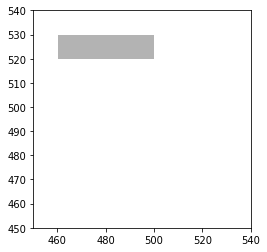

In [0]:
plotConstr(result[0:4], 450, 540)